# Day2.1 Binary Classification

### 실습 목표
- MNIST 데이터셋에서 0과 1 이미지를 예측하는 모델을 구축하고 학습 및 평가를 진행
- 모델의 학습 과정(Back Propagation)이 코드 상에서 어떻게 구현되는지 확인하고, Trainig Curve와 Learning Rate에 따른 성능 변화를 확인  
  <details>
  <summary> 데이터셋 상세 정보 </summary>

  MNIST 데이터셋 : 0부터 9까지의 흑백 숫자 이미지들로 이루어진 데이터 셋, 28x28 크기, 7만장

  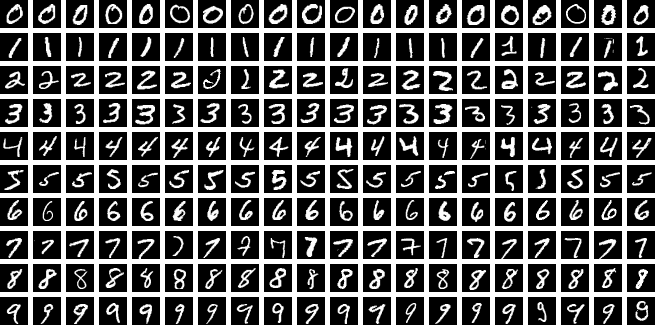

  </details>


## 0. Setting

- 런타임 > 런타임 유형 변경 > GPU



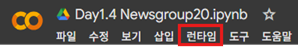

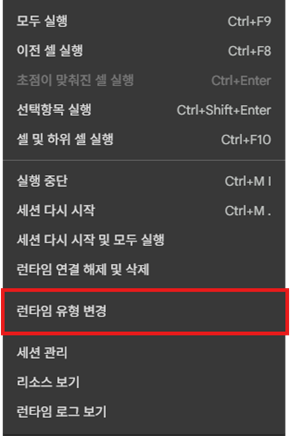

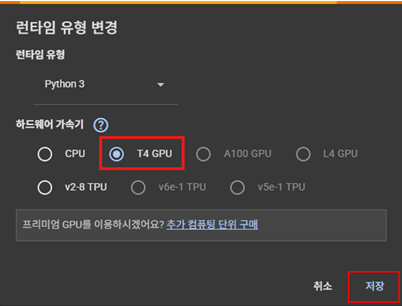

- 필요한 라이브러리 설치 및 호출

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

- GPU 설정

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


- 시드 고정

    - 동일한 실습 환경에서도 모델의 학습 결과가 일관되도록 랜덤성을 최소화
    - 이를 통해 코드 실행 시 매번 동일한 결과를 재현

In [ ]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

## 1. MNIST 데이터셋 준비

#### 1.1 MNIST 데이터셋 불러오기
-  현재 불러오고자 하는 데이터는 <font color="red">이미지</font> → 모델이 입력으로 받기 위해 <font color="red">Tensor</font>로 변형

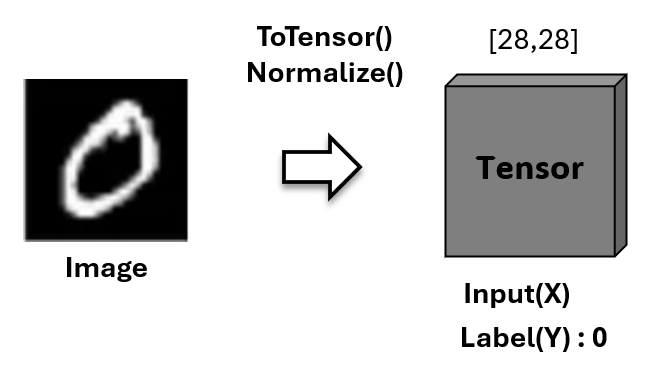

  - Tensor
    - Pytorch 에서 사용하는 기본적인 데이터 타입
    - Pytorch에서 사용되기 위한 모든 데이터는 Tensor로 변환되어야 함
  - `transforms`
    - Tensor를 변환/변형해주는 함수들을 저장하고 있는 Pytorch 라이브러리
  - `transforms.ToTensor()`
    - ToTensor는 일반적으로 사용되는 이미지 → Tensor 변환 함수로써, 입력 데이터가 이미지 형식인 경우 ToTensor를 사용하여 텐서 형식으로 변환 가능.
    - 이미지를 [채널의 수(C),이미지의 높이(H),이미지의 너비(W)] 크기의 Tensor로 변경
      - 채널의 수는 흑백 이미지인 경우 1이거나 X, 컬러 이미지인 경우 3 (R,G,B)
  - `transforms.Normalize()`
    - Tensor의 값을 정규화를 통해 동일한 범위의 값이 되도록 함
    - 모델에 데이터(Tensor)가 입력으로 들어갔을 때 보다 안정화된 학습이 가능함
  - `transforms.Compose([transform1,transform2])`
    - 여러가지 transform을 동시에 사용하고 싶은 경우 `transforms.Compose`를 통해 원하는 transform들을 묶어서 같이 사용할 수 있음


In [ ]:
# 이미지를 텐서 형태로 바꾸어줄 함수를 미리 설정해두기
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

- `datasets.MNIST` 클래스로 MNIST 데이터셋 불러오기
  - `datasets`
    - 딥러닝 학습에 자주 사용되는 데이터셋들을 제공해주는 PyTorch 라이브러리
    - 단순히 데이터를 제공해주는 것뿐만 아니라, 데이터를 쉽게 확인/저장/관리할 수 있도록 해주는 `Dataset`이라는 특수한 클래스에 담아서 제공해줌
  - `datasets.MNIST`는 **MNIST 데이터셋**을 저장하고 있는 `Dataset` 클래스
    - 총 7만장의 **0~9까지의 흑백 숫자 이미지 데이터**와 그에 대한 Label 정보를 담고 있음
    - `Dataset.data` : Tensor 형태로 변환된 MNIST 이미지 데이터
      - Indexing을 통해 하나씩 확인해볼 수도 있음
    - `Dataset.targets` : 각 이미지 데이터의 Label
      <details>

      - `root` 는 학습/테스트 데이터가 저장되는 경로

      - `train` 은 학습용 또는 테스트용 데이터셋 여부를 지정

      - `download=True` 는 한번도 데이터셋을 불러온 적 없는 경우 직접 다운로드

      - `transform`은 데이터를 어떻게 변형할 지 결정
      </details>
  - Train 데이터와 Test 데이터를 각각 불러옴
    - 전체 7만장 중 Train 데이터는 6만장, Test 데이터는 1만장

In [ ]:
# Train 데이터셋 불러오기
train_full_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# Test 데이터셋 불러오기
test_full_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.05MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.97MB/s]


MNIST Train 데이터 셋 정보 : Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

이미지 데이터의 크기 : torch.Size([60000, 28, 28])

각 이미지 데이터의 Label : tensor([5, 0, 4,  ..., 5, 6, 8])




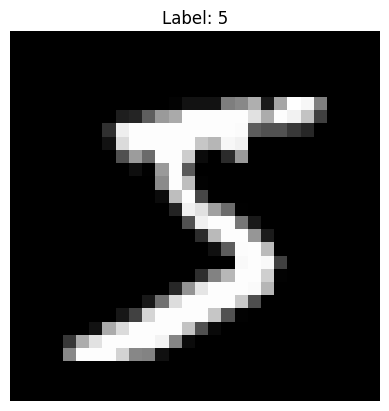

In [ ]:
# 불러온 데이터셋 확인하기
print(f'MNIST Train 데이터 셋 정보 : {train_full_dataset}\n')
print(f'이미지 데이터의 크기 : {train_full_dataset.data.shape}\n')
print(f'각 이미지 데이터의 Label : {train_full_dataset.targets}\n\n')

import matplotlib.pyplot as plt

# 첫번째 데이터 선택해서 확인해보기
image = train_full_dataset.data[0] # 첫번째 이미지 데이터
label = train_full_dataset.targets[0] # 첫번쨰 이미지 데이터의 Label

# 시각화
plt.imshow(image, cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

#### 1.2 데이터셋 전처리

- 현재는 0과 1 이미지만을 분류하려함 (Binary Classification)
- 불러온 데이터셋에서 0과 1에 대한 데이터만 추출하여 새로운 데이터셋을 구축
- `Subset(Dataset,Index)` 클래스
  - 원본 데이터셋에서 원하는 데이터만을 추출하여 새로운 데이터셋을 구축해주는 클래스
  - 데이터의 인덱스(데이터셋 안에서 몇번째 데이터인지)를 제공하여 원하는 데이터를 선택할 수 있음

In [ ]:
# 0과 1에 해당되는 데이터의 Index를 뽑기
train_indices = torch.where((train_full_dataset.targets == 0) | (train_full_dataset.targets == 1))[0]
test_indices = torch.where((test_full_dataset.targets == 0) | (test_full_dataset.targets == 1))[0]

# Subset으로 0과 1에 대한 데이터로만 이루어진 새로운 데이터셋 구축
train_dataset = Subset(train_full_dataset, train_indices)
test_dataset = Subset(test_full_dataset, test_indices)

#### 1.3 DataLoader
- `DataLoader(Dataset)` 클래스
  - 모델이 데이터를 입력으로 받을 때, 전체 데이터를 한번에 입력 받는건 힘듦
  - 따라서 데이터를 적절히 나누어 차례차례 입력해주는 `DataLoader` 클래스가 필요함
  - 이때, 나누어진 데이터 뭉치들을 **Batch**라고 부르며, Batch에 속한 데이터의 개수를 **Batch Size**라고 부름
    <details>

    - `batch_size` 는 Batch Size를 결정

    - `shuffle` 은 나누어진 데이터를 기존 `Dataset` 클래스에 저장된 순서대로 내보낼지, 혹은 순서를 임의로 내보낼지를 결정
      - 보통 학습의 경우 Shuffle을 True, 평가의 경우 False로 설정

    - `worker_init_fn`,`generator` : 시드 고정을 위한 옵션
    </details>
  - Batch는 데이터들과 그 데이터들의 Label로 이루어져 있음

In [ ]:
# 시드를 고정하기 위한 설정
g = torch.Generator()
g.manual_seed(42)

# DataLoader 구축
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, worker_init_fn=seed_worker,generator=g)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, worker_init_fn=seed_worker,generator=g)

- DataLoader를 구축하고 나면, 실제로 데이터를 Batch 단위로 확인할 수 있음

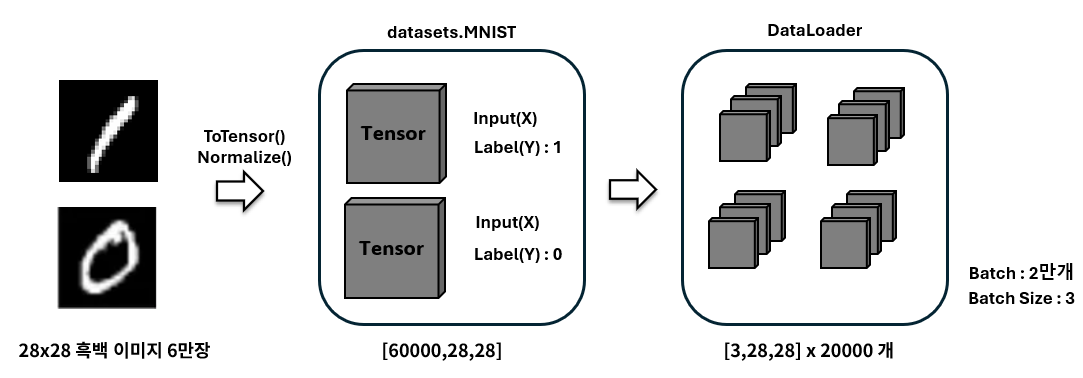

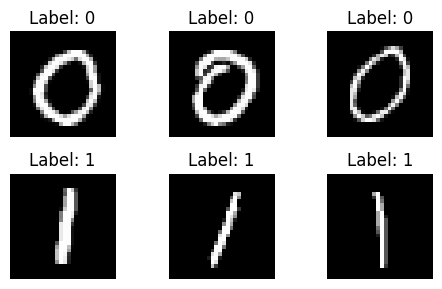

In [ ]:
# 불러온 데이터 확인하기
import matplotlib.pyplot as plt

examples = next(iter(train_loader)) # 첫번째 데이터 Batch를 반환
images, labels = examples # Batch에서 데이터와 label을 분리

# 0과 1을 각각 시각화해서 확인할 수 있음
images = images.cpu()
labels = labels.cpu()

zero_indices = (labels == 0).nonzero(as_tuple=True)[0][:3]
one_indices = (labels == 1).nonzero(as_tuple=True)[0][:3]

selected_indices = torch.cat([zero_indices, one_indices])

fig, axes = plt.subplots(2, 3, figsize=(5, 3))

for idx, ax in enumerate(axes.flat):
    img = images[selected_indices[idx]]
    label = labels[selected_indices[idx]]

    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f"Label: {int(label.item())}")
    ax.axis('off')

plt.tight_layout()
plt.show()

## 2. 모델 구축, 학습, 평가


  #### 2.0 모델 구축 연습
  - Neural Network 모델을 구축해보기

  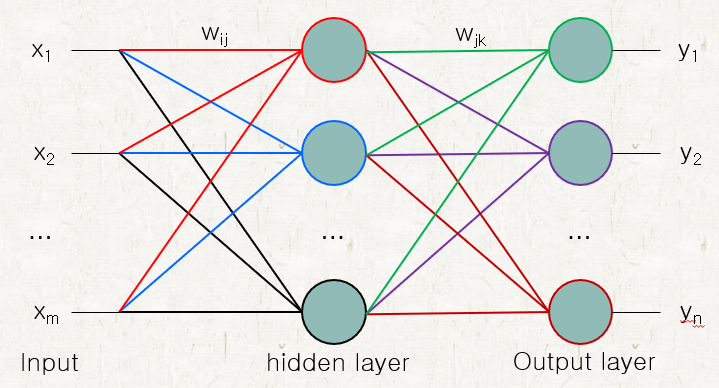

  - `nn.Module` 클래스
    - Neural Network를 만들기 위해 PyTorch에서 제공하는 클래스
    - 우리는 해당 클래스를 상속받아 아래의 2가지 함수를 통해 우리가 원하는 구조만 작성해서 편리하게 Neural Network를 구현할 수 있음
    - `__init__(self)` : 모델의 layer들을 정의하기 위한 함수
    - `forward(self, x)` : 모델에 입력 x가 들어왔을 때, `__init__`에서 선언한 layer들을 어떻게 통과시켜 모델의 output을 얻을지를 정의하는 함수

In [ ]:
class MyNeuralNetwork(nn.Module):
    def __init__(self):
        super(MyNeuralNetwork, self).__init__()
        '''
        원하는 layer를 정의하는 부분
        '''

    def forward(self, x):
        '''
        정의한 layer들에 input을 어떻게 통과시켜 모델의 output을 얻을지 정의하는 부분
        '''
        return output

  - **Layer의 종류**

  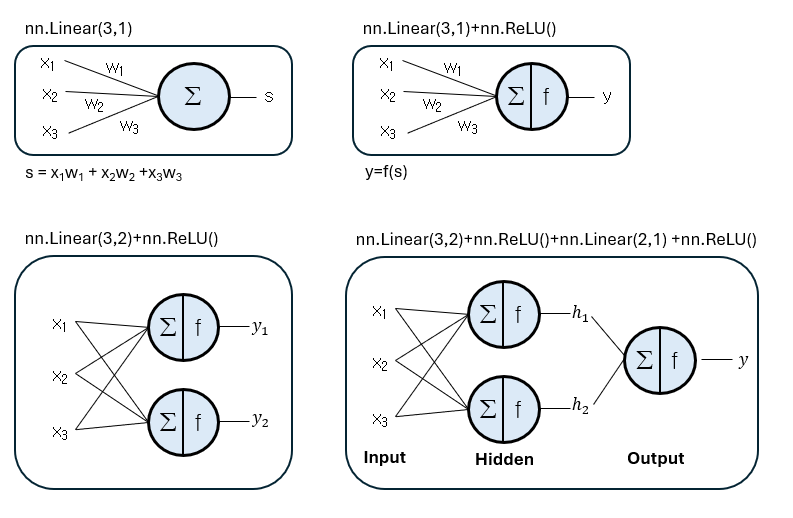

    - `nn.Linear(input_dim, output_dim)`
      - Neural Network에서 하나의 Layer를 담당
      - Linear Layer를 일반적으로 **Fully Connected Layer**라고 부름
      - `input_dim` : Layer로 입력되는 데이터의 크기(차원)
      - `output_dim` : Layer를 통과하고 난 뒤 데이터의 크기(차원)
      - input_dim X output_dim 크기의 weight를 가지며, 학습을 통해 업데이트할 수 있음
    - `nn.Sigmoid()` : Sigmoid Activation 함수
    - `nn.ReLU()` : ReLU Activation 함수

In [ ]:
# Fully Connected Layer를 1개 정의
fully_connected_layer = nn.Linear(3,1)
print(f'Fully Connected Layer의 Weight(w1,w2,w3) 크기 : {fully_connected_layer.weight.shape}')

Fully Connected Layer의 Weight(w1,w2,w3) 크기 : torch.Size([1, 3])


In [ ]:
class MyNeuralNetwork(nn.Module):
    def __init__(self):
        super(MyNeuralNetwork, self).__init__()

        self.layer1 = nn.Linear(3,2)
        self.activation1 = nn.ReLU()
        self.layer2 = nn.Linear(2,1)
        self.activation2 = nn.ReLU()

    def forward(self, x):

        x_passed = self.layer1(x)
        h = self.activation1(x_passed)
        h_passed = self.layer2(h)
        y = self.activation2(h_passed)

        return y

- `nn.Sequential(layers)` 클래스
  - 다수의 layer를 하나로 묶어주는 클래스
  - `forward` 함수에서 입력이 layer를 통과하는 과정을 하나하나 작성할 필요없이, nn.Sequential 클래스로 한번에 layer를 통과시킨 output을 얻을 수 있음

In [ ]:
class MyNeuralNetwork(nn.Module):
    def __init__(self):
        super(MyNeuralNetwork, self).__init__()

        self.layers = nn.Sequential(
        nn.Linear(3,2),
        nn.ReLU(),
        nn.Linear(2,1),
        nn.ReLU())

    def forward(self, x):

        y = self.layers(x) # 한번에 모든 layer를 통과한 output을 얻음

        return y

- Neural Network 모델을 구축(정의)했다면 실제로 아래와 같이 생성할 수 있음
- 생성한 모델은 준비한 데이터셋으로 학습 및 평가가 가능함

In [ ]:
model = MyNeuralNetwork().to(device)

- Exercise
  - 아래의 그림과 같은 Neural Network를 구축해보기
  - Activation 함수는 ReLU Activate 함수 사용하기
  - `nn.Sequential` 사용하기

  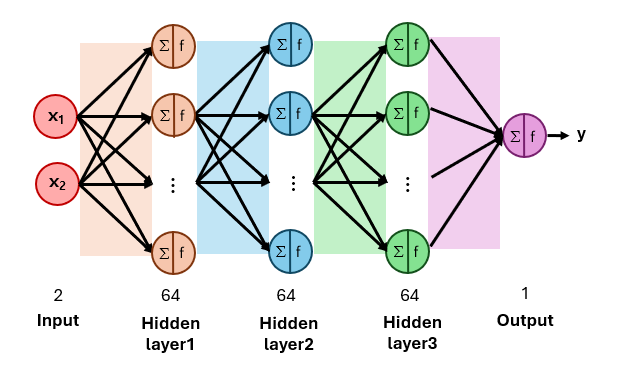

In [ ]:
class DeepNeuralNetwork(nn.Module):
    def __init__(self):
        super(MyNeuralNetwork, self).__init__()
        '''
        원하는 layer를 정의하는 부분
        '''

    def forward(self, x):
        '''
        정의한 layer들에 input을 어떻게 통과시켜 모델의 output을 얻을지 정의하는 부분
        '''
        return y

model = DeepNeuralNetwork().to(device)

#### 2.1 MNIST를 위한 Binary Classification 모델 구축
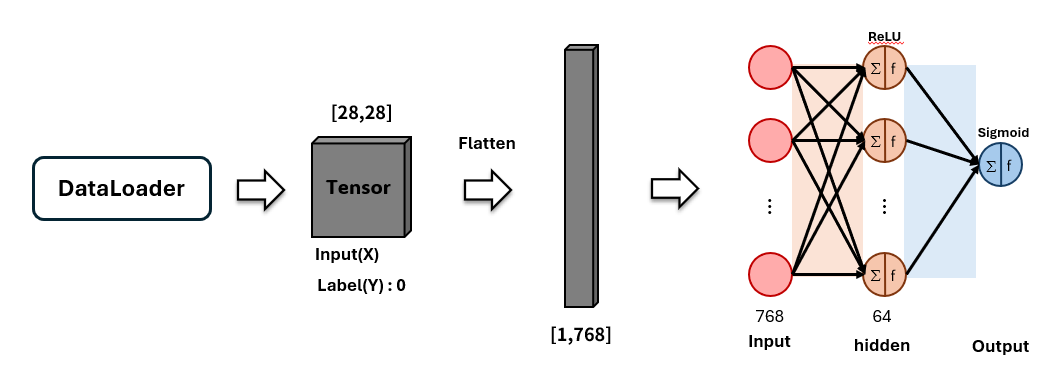
  - Neural Network의 Input은 1차원 Tensor(벡터)이므로, 현재 2차원 Tensor 형태인 이미지를 1차원으로 바꾸어줘야함
    - 보통 1차원 Tensor로 변환하는 과정을 **Flattening**이라고 함
  - 총 2개의 fully connected layer(nn.Linear layer)로 구성된 Neural Network 모델
    - 입력되는 데이터의 크기는 28x28=786
    - Output의 크기는 1 (0 OR 1)
  - 각 첫번째 fully connected layer는 ReLU activation 함수를, 마지막 fully connected layer는 sigmoid activation 함수를 가지고 있음

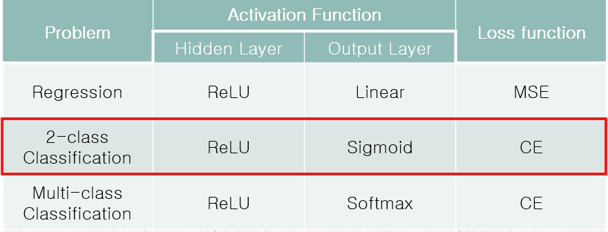

In [ ]:
# 모델 정의
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        y = self.layers(x)
        return y

# 모델 구축
model = BinaryClassifier().to(device)

### 2.2 모델 학습 준비

- **Loss Function** : 모델의 output이 실제 Label과 얼마나 유사한지를 나타내는 함수
  
  - 두 값이 서로 유사할수록 함수값이 작아지며, 이 함수를 최소화 하는 것이 모델의 최종 학습 목표
  - `nn.MSE()` : MSE Loss Function
  - `nn.BCELoss()` : (Binary Clssification을 위한) Cross Entropy Loss Function

  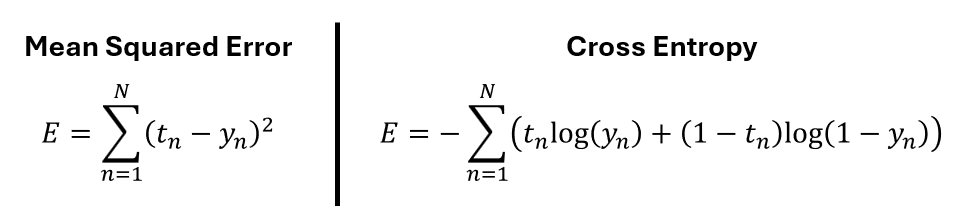

- **Optimizer** : Loss function이 최소화되도록 모델의 Weight를 업데이트 하는 역할 (Gradient Descent)
  - `nn.SGD(model.parameters(), learning rate)` : Gradient Descent를 수행하는 Optimizer
  - `model.parameters()` : Neural Network 모델의 Weight들

  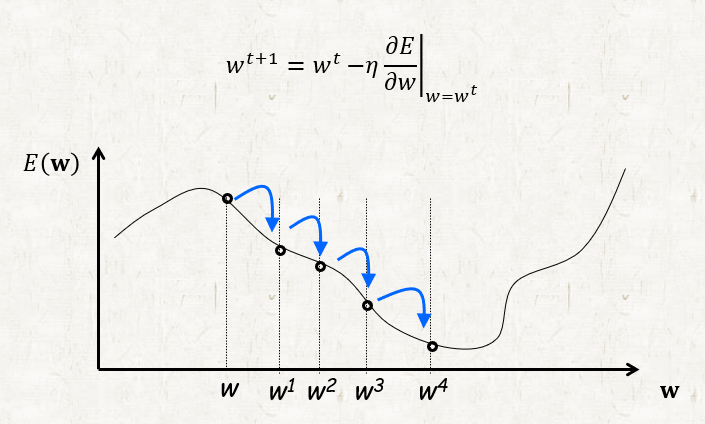

- Learning Rate(η) : 모델이 Weight를 얼마나 업데이트 할 지를 결정하는 역할

In [ ]:
loss_function = nn.BCELoss() # Loss function
optimizer = optim.SGD(model.parameters(), lr=0.001) # Optimizer, Learning Rate : 0.001

### 2.3 모델 학습 및 평가

- **모델 학습** : Train 데이터셋으로, 모델의 output이 실제 정답과 유사해지도록, 즉 Loss function이 최소화되도록 Optimizer를 통해 학습

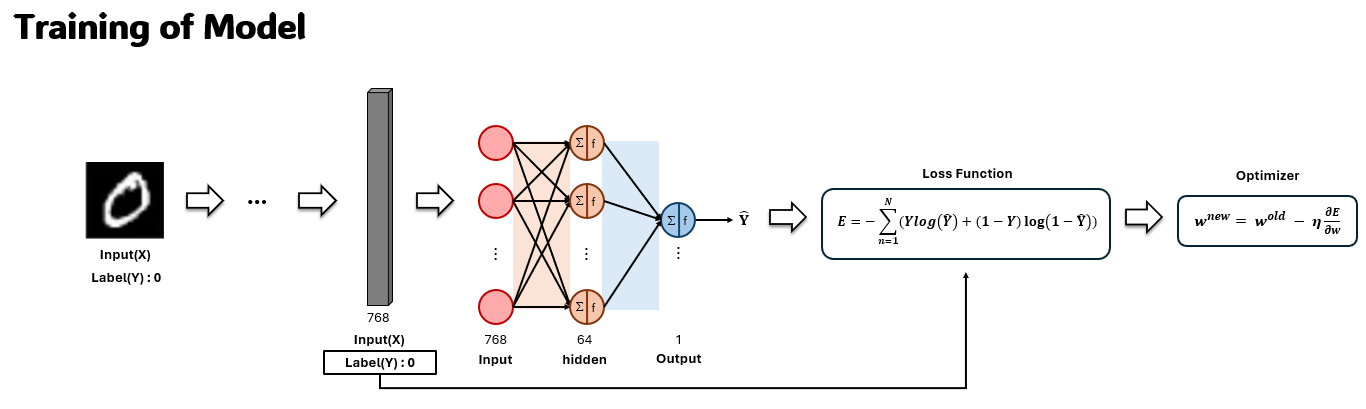

0. `model.train()` 으로 모델을 학습 상태로 전환
1. DataLoader에서 Train 데이터를 불러오기 (input,labels)
2. 모델에 input을 넣고 output을 출력하기
3. 모델의 output과 정답 labels으로 loss 계산하기
4. loss의 미분값을 계산하고 optimizer로 Gradient Descent 수행하기
  - `loss.backward()` : 계산한 loss의 미분값을 계산
  - `optimizer.step()` : 계산한 loss의 미분값으로 Gradient Descent를 진행
  - `opimizer.zero_grad()` : 계산한 미분값들을 비워주는 역할, 이 함수가 없으면 미분값들이 계속 누적되어 계산되기에 필수적으로 호출 필요
5. (선택) 학습마다 Loss 값(Training Loss)를 확인하기 위해 Loss 값을 저장하고 반환

In [ ]:
# train 함수
def train(model, loader, loss_function, optimizer):
    # model을 학습 상태로 설정
    model.train()
    running_loss = 0.0

    for inputs, labels in loader:
        # Dataloader로 데이터를 불러옴
        # 데이터는 input(X)과 label(Y)로 이루어짐
        inputs = inputs.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        # 모델에 input을 입력하여 결과를 얻음
        outputs = model(inputs)

        # Loss를 계산
        loss = loss_function(outputs, labels)

        optimizer.zero_grad() # Optimizer가 기존에 계산한 결과물들을 초기화하기 위한 과정
        loss.backward() # Loss의 미분 값(Gradient)을 구함
        optimizer.step() # Loss의 미분 값을 활용하여 weight를 업데이트 (Gradient Descent)

        running_loss += loss.item() # 데이터의 Loss를 저장

    # Train Loss (전체 데이터의 평균 Loss) 계산
    avg_loss = running_loss / len(loader)
    return avg_loss

- **모델 평가** : 학습한 모델이 Test 데이터셋의 라벨(여기서는 0 or 1)을 얼마나 잘 예측하는지 평가
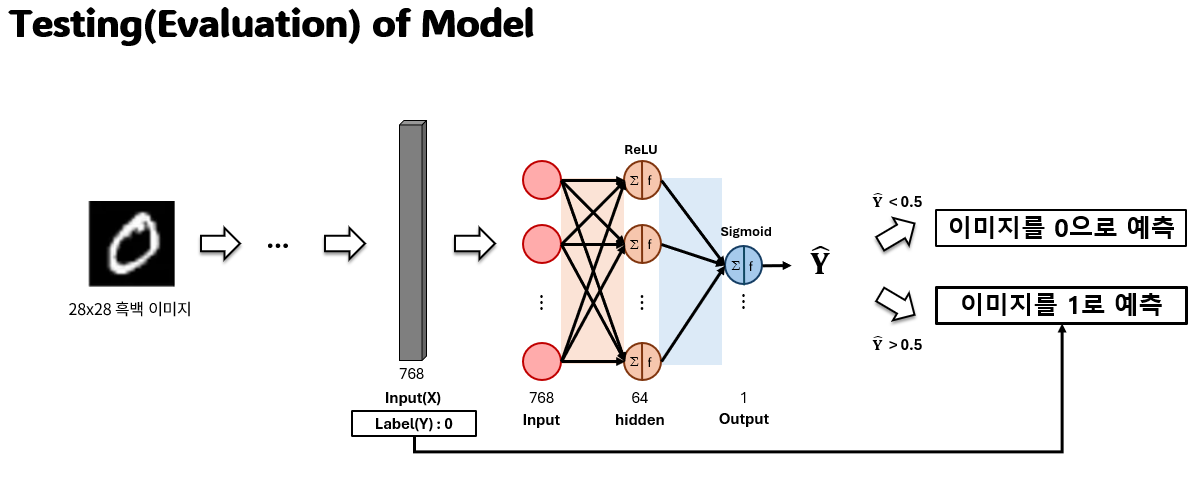

1. `model.eval()`로 모델을 평가 상태로 전환
2. DataLoader로 Test 데이터 불러오기 (input, labels)
3. 모델에 input을 넣고 output을 출력하기
4. 모델의 output이 0.5 이상이라면 1, 0.5 이하라면 0으로 예측했다고 판단
5. 모델의 예측과 정답 label이 얼마나 유사한지를 비교하여 성능을 평가
  - 성능 평가 지표
    - Test Loss : Test 데이터셋에 대한 모델의 평균 Loss 값
    - Test Accuracy : 모델이 Test 데이터셋에 있는 전체 데이터 중에서 라벨을 올바르게 맞춘 비율
      - (모델이 라벨을 맞춘 데이터 수 / 전체 데이터 수)

In [ ]:
# evaluate 함수
def evaluate(model, loader, loss_function):
    # model을 평가 상태로 설정
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            # Dataloader로 데이터 (input, label)를 불러옴
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            # 모델에 input을 입력한 결과를 얻음
            outputs = model(inputs)

            # 모델의 output이 0.5 이상이라면 1, 0.5 이하라면 0으로 예측했다고 판단
            preds = (outputs > 0.5).int()

            # 데이터에 대한 모델의 output과 정답 label 간의 유사도를 알 수 있는 Loss를 계산 후 저장
            loss = loss_function(outputs, labels)
            running_loss += loss.item()

            # 데이터에 대해 모델이 예측한 결과와 label을 비교하여 모델이 정확히 예측한 데이터 개수를 측정
            labels_int = labels.int()
            correct += (preds == labels_int).sum().item()
            total += labels.size(0)

    # Test Loss (전체 데이터의 평균 Loss) 계산
    avg_loss = running_loss / len(loader)
    # Test Accuracy (모델이 정확히 예측한 데이터 개수 / 전체 데이터 수) 계산
    accuracy = correct / total

    return avg_loss, accuracy

- 위에서 선언한 `train`과 `evaluate` 함수로 실제로 모델을 학습 및 평가
  - 모델을 한 번 학습할 때마다, 모델의 성능을 평가
    - Train Loss / Test Loss / Test Accuracy 출력
  - 총 10번 학습 (Epoch : 10)

In [ ]:
# 시드 고정
set_seed(20)

# 학습 및 평가
num_epochs = 10

for epoch in range(num_epochs):
    # 모델 학습
    train_loss = train(model, train_loader, loss_function, optimizer)
    # 모델 평가
    test_loss, test_acc = evaluate(model, test_loader, loss_function)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc*100:.2f}%")

Epoch [1/10] - Train Loss: 0.6742 | Test Loss: 0.6482 | Test Accuracy: 58.39%
Epoch [2/10] - Train Loss: 0.6284 | Test Loss: 0.6022 | Test Accuracy: 79.81%
Epoch [3/10] - Train Loss: 0.5831 | Test Loss: 0.5556 | Test Accuracy: 91.63%
Epoch [4/10] - Train Loss: 0.5364 | Test Loss: 0.5074 | Test Accuracy: 95.79%
Epoch [5/10] - Train Loss: 0.4884 | Test Loss: 0.4586 | Test Accuracy: 97.40%
Epoch [6/10] - Train Loss: 0.4403 | Test Loss: 0.4106 | Test Accuracy: 98.49%
Epoch [7/10] - Train Loss: 0.3939 | Test Loss: 0.3651 | Test Accuracy: 98.87%
Epoch [8/10] - Train Loss: 0.3506 | Test Loss: 0.3236 | Test Accuracy: 99.15%
Epoch [9/10] - Train Loss: 0.3114 | Test Loss: 0.2865 | Test Accuracy: 99.29%
Epoch [10/10] - Train Loss: 0.2768 | Test Loss: 0.2540 | Test Accuracy: 99.34%


- 모델 예측 결과 시각화

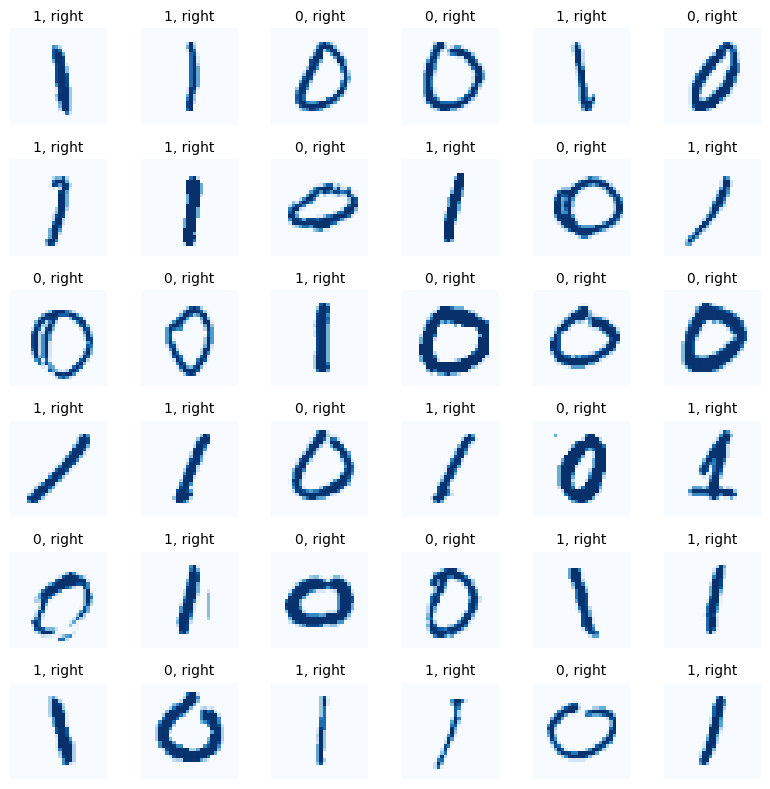

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

labels_map = {
    0: "0",
    1: "1"
}

# 6x6 개의 데이터를 시각화
columns = 6
rows = 6
fig = plt.figure(figsize=(8,8))

model.eval()
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(test_dataset))

    # 확인하고 싶은 데이터셋 구성
    input_img = test_dataset[data_idx][0].unsqueeze(dim=0).to(device)
    true_label = test_dataset[data_idx][1]

    # 모델로 데이터의 label을 예측
    with torch.no_grad():
        output = model(input_img)
        pred_prob = output.squeeze().item()
        pred_label = 1 if pred_prob > 0.5 else 0

    fig.add_subplot(rows, columns, i)

    if pred_label == true_label:  # 모델이 정답 label을 맞추었다면 파란색으로 표시
        plt.title(f"{labels_map[pred_label]}, right", fontsize=10)
        cmap = 'Blues'
    else:  # 모델이 정답 label을 맞추지 못햇다면 빨간색으로 표시
        plt.title(f"N {labels_map[pred_label]} / T {labels_map[true_label]}", fontsize=10)
        cmap = 'Reds'

    # 데이터 시각화
    plot_img = test_dataset[data_idx][0][0,:,:].cpu()
    plt.imshow(plot_img, cmap=cmap)
    plt.axis('off')

plt.tight_layout()
plt.show()

## 3. Learning Curve & Learning Rate

#### 3.1 Learning Curve
  - 모델을 학습함에 따라 Train Loss가 어떻게 변하는지를 나타낸 그래프

  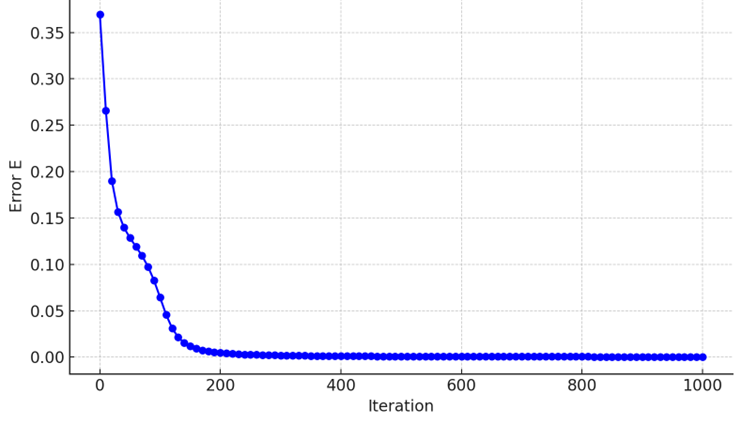

In [ ]:
# 모델의 학습 횟수
num_epochs = 10

# 모델 정의
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x)

# 모델 생성
model = BinaryClassifier().to(device)

# Loss function & Optimizer 정의
loss_function = nn.BCELoss() # Loss function
optimizer = optim.SGD(model.parameters(), lr=0.001) # Optimizer, Learning Rate : 0.001

# 시드 고정
set_seed(20)

# 학습 및 평가
train_losses = [] # train_loss를 저장할 리스트
for epoch in range(num_epochs):
    # 모델 학습
    train_loss = train(model, train_loader, loss_function, optimizer)
    train_losses.append(train_loss) # 학습 마다 train_loss를 저장
    # 모델 평가
    test_loss, test_acc = evaluate(model, test_loader, loss_function)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")

Epoch [1/10] - Train Loss: 0.5210 | Test Loss: 0.3796 | Test Acc: 98.35%
Epoch [2/10] - Train Loss: 0.2928 | Test Loss: 0.2078 | Test Acc: 99.39%
Epoch [3/10] - Train Loss: 0.1687 | Test Loss: 0.1242 | Test Acc: 99.57%
Epoch [4/10] - Train Loss: 0.1090 | Test Loss: 0.0836 | Test Acc: 99.57%
Epoch [5/10] - Train Loss: 0.0783 | Test Loss: 0.0616 | Test Acc: 99.67%
Epoch [6/10] - Train Loss: 0.0607 | Test Loss: 0.0482 | Test Acc: 99.67%
Epoch [7/10] - Train Loss: 0.0495 | Test Loss: 0.0395 | Test Acc: 99.72%
Epoch [8/10] - Train Loss: 0.0419 | Test Loss: 0.0334 | Test Acc: 99.81%
Epoch [9/10] - Train Loss: 0.0364 | Test Loss: 0.0289 | Test Acc: 99.81%
Epoch [10/10] - Train Loss: 0.0323 | Test Loss: 0.0255 | Test Acc: 99.81%


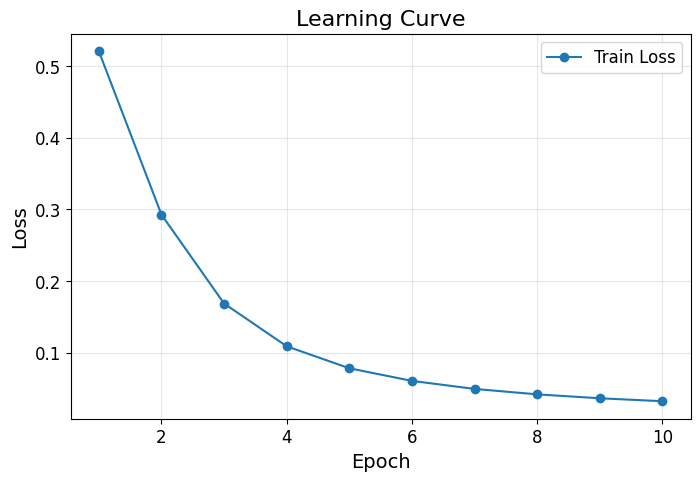

In [ ]:
# 저장한 train_loss를 시각화
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), train_losses, marker='o', label='Train Loss')
plt.title('Learning Curve', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.show()

- 200번 학습했을 때의 Training Curve

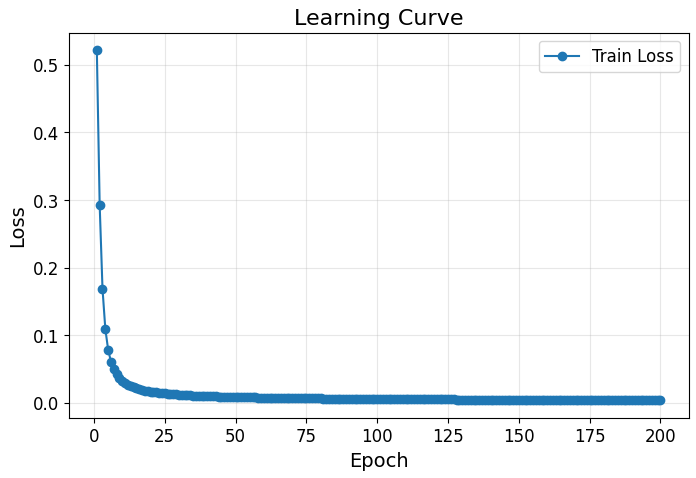

####3.2 Learning Rate

- Learning Rate(η) : 모델이 Weight를 **얼마나 업데이트** 할 지를 결정하는 역할
  - 매우 큰 Learning Rate : Weight를 너무 많이 업데이트하여 성능이 좋지 않음
  - 너무 적은 Learning Rate : Weight를 너무 적게 업데이트하여 성능이 좋지 않음
  - **적절한 Learning Rate** : Weight를 적절히 업데이트하여 좋은 성능을 얻을 수 있음
  
   ![image.png](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbeNGrz%2FbtqQzRMQAQx%2FE5HgPj8oe4AugHgHxS7RlK%2Fimg.png)

- Learning Rate에 따른 성능 시각화

In [ ]:
# Learning Rate
learning_rates = [0.00001, 0.001, 10]

# 모델 정의
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x)

test_accuracies_dict = {}

for learning_rate in learning_rates:
  print(f"=====================Learning Rate : {learning_rate}=====================")
  # 모델 생성
  model = BinaryClassifier().to(device)

  # Loss function & Optimizer 정의
  loss_function = nn.BCELoss() # Loss function
  optimizer = optim.SGD(model.parameters(), lr=learning_rate) # Optimizer

  test_accuracies = []

  # 시드 고정
  set_seed(20)

  # 모델의 학습 횟수
  num_epochs = 5

  # 학습 및 평가
  train_losses = []
  for epoch in range(num_epochs):

      # 모델 학습
      train_loss = train(model, train_loader, loss_function, optimizer)
      # 모델 평가
      test_loss, test_acc = evaluate(model, test_loader, loss_function)
      test_accuracies.append(test_acc * 100)
      print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")

  test_accuracies_dict[learning_rate] = test_accuracies

=====================Learning Rate : 1e-05=====================
Epoch [1/5] - Train Loss: 0.6906 | Test Loss: 0.6869 | Test Acc: 46.52%
Epoch [2/5] - Train Loss: 0.6855 | Test Loss: 0.6817 | Test Acc: 46.86%
Epoch [3/5] - Train Loss: 0.6806 | Test Loss: 0.6767 | Test Acc: 47.99%
Epoch [4/5] - Train Loss: 0.6757 | Test Loss: 0.6717 | Test Acc: 49.74%
Epoch [5/5] - Train Loss: 0.6709 | Test Loss: 0.6668 | Test Acc: 53.19%
=====================Learning Rate : 0.001=====================
Epoch [1/5] - Train Loss: 0.5213 | Test Loss: 0.3796 | Test Acc: 98.49%
Epoch [2/5] - Train Loss: 0.2927 | Test Loss: 0.2078 | Test Acc: 99.39%
Epoch [3/5] - Train Loss: 0.1688 | Test Loss: 0.1244 | Test Acc: 99.57%
Epoch [4/5] - Train Loss: 0.1092 | Test Loss: 0.0838 | Test Acc: 99.57%
Epoch [5/5] - Train Loss: 0.0785 | Test Loss: 0.0617 | Test Acc: 99.62%
=====================Learning Rate : 10=====================
Epoch [1/5] - Train Loss: 46.2668 | Test Loss: 45.9712 | Test Acc: 53.66%
Epoch [2/5] - Tra

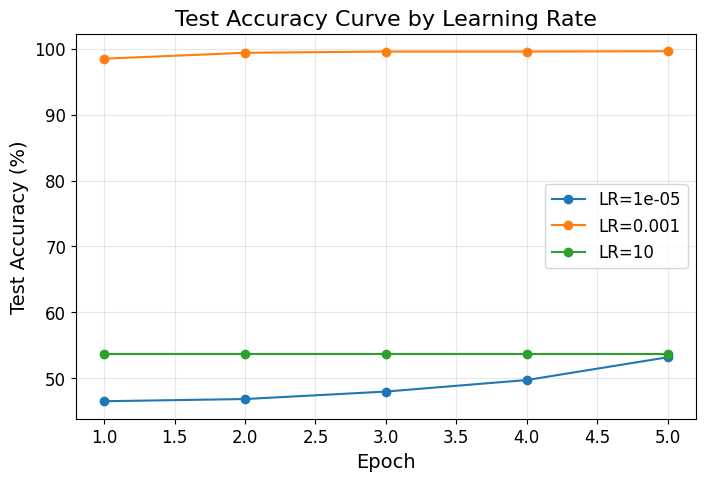

In [ ]:
plt.figure(figsize=(8,5))
for lr, accs in test_accuracies_dict.items():
    plt.plot(range(1, num_epochs+1), accs, marker='o', label=f"LR={lr}")

plt.title('Test Accuracy Curve by Learning Rate', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Test Accuracy (%)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.show()